# Глубокое обучение


## Тема 4. Авторегрессионные модели. Сети LSTM

Ранее мы рассмотрели два семейства генеративных моделей, в которых были задействованы скрытые переменные: вариационные автокодировщики (VAE) и генеративно-состязательные сети (GAN). В обоих случаях вводилась новая переменная с вероятностным распределением, из которого легко выполнить выборку, и генеративная модель училась декодировать эту переменную обратно в исходное признаковое пространство.

Авторегрессионная модель (ARM) прогнозирует будущее поведение на основе данных о прошлом поведении. Модели ARM представляют собой модели  регрессии, в которых переменная отклика $Y$ в определенный момент времени зависит от переменных-предикторов $X$ и предыдущих значений переменной отклика $Y$.

По цепному правилу вероятности мы можем записать любое совместное распределение по $T$ переменным $\mathbf{x}_{1},...\mathbf{x}_{T}$, где $\mathbf{x}_{t}\in\mathcal{X}$ представляет собой $i$-е наблюдение, следующим образом:

$$p\left(\mathbf{x}_{1:T}\right)=p\left(\mathbf{x}_{1}\right)p\left(\mathbf{x}_{2}\mid\mathbf{x}_{1}\right)p\left(\mathbf{x}_{3}\mid\mathbf{x}_{2},\mathbf{x}_{1}\right)...=\prod_{t=1}^{T}p\left(\mathbf{x}_{t}\mid\mathbf{x}_{1:t-1}\right),$$
где распределение для начального состояния определяется как $p\left(\mathbf{x}_{1}\mid\mathbf{x}_{1:0}\right)=p\left(\mathbf{x}_{1}\right)$. 

Авторегрессионные модели также могут зависеть от произвольных входных данных или контекста $c$, чтобы определять $p\left(\mathbf{x}\mid c\right)$.

Хотя разложение $p\left(\mathbf{x}_{1:T}\right)$, приведенное выше, является общим, каждый член в этом выражении (т. е. каждое условное распределение $p\left(\mathbf{x}_{t}\mid\mathbf{x}_{1:t-1}\right)$ становится все более и более сложным, поскольку оно зависит от возрастающего числа аргументов, что замедляет вычисление условных распределений и оценка их параметров требует больше данных.

Один из подходов к решению этой трудноразрешимой проблемы состоит в том, чтобы сделать марковское предположение, что приводит к марковской модели $p\left(\mathbf{x}_{t}\mid\mathbf{x}_{1:t-1}\right)=p\left(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}\right)$ (такую модель также называют авторегрессионной моделью первого порядка). К сожалению, марковское предположение является очень ограничивающим. Один из способов ослабить его и заставить $\mathbf{x}_{t}$ зависеть от всего прошлого $\mathbf{x}_{1:t-1}$ без явной регрессии по этим переменным — это предположить, что прошлое можно сжать в скрытое состояние $\mathbf{z}_{t}$. Если $\mathbf{z}_{t}$ является детерминированной функцией прошлых наблюдений $\mathbf{x}_{1:t-1}$, то результирующая модель известна как рекуррентная нейронная сеть. 



### Long Short-Term Memory Network (LSTM)

Сеть долговременной краткосрочной памяти LSTM — это особый тип рекуррентной нейронной сети (RNN). Сети RNN содержат рекуррентный слой (или ячейку), который способен обрабатывать последовательные данные, превращая свои собственные выходные данные в определенный временной шаг в часть входных данных для следующего временного шага.

Когда сети RNN были впервые представлены, рекуррентные слои были очень простыми и состояли исключительно из оператора $\tanh$, который гарантировал, что информация, передаваемая между временными шагами, масштабировалась между $–1$ и $1$. Однако было показано, что этот подход страдает от проблемы исчезающего градиента и плохо масштабируется для длинных последовательностей данных.

Сети LSTM были впервые представлены в 1997 году в статье Зеппа Хохрайтера и Юргена Шмидхубера. В статье авторы описывают, как сети LSTM не страдают от проблемы исчезающего градиента, с которой сталкиваются обычные сети RNN, и их можно обучить на последовательностях длиной в сотни временных шагов. С тех пор архитектура LSTM была адаптирована и улучшена, ее варианты, такие как управляемые (gated) сети RNN, теперь широко используются и доступны в виде слоев в Keras. Сети LSTM применялись для решения широкого спектра задач, связанных с последовательными данными, включая прогнозирование временных рядов, анализ настроений и классификацию аудио. Рассмотрим использование сети LSTM для решения задачи генерации текста.

# 🥙 Сеть LSTM для набора данных Recipes

Будем использовать набор данных Epicurious Recipes, доступный через Kaggle. Это набор из более чем 20 тысяч рецептов с сопроводительными метаданными, такими как информация о пищевой ценности и списки ингредиентов. Можно загрузить набор данных из Kaggle на локальный диск и потом загрузить данные в программу следующим образом.

In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.__version__

'2.18.0'

In [3]:
import json
import re
import string

from tensorflow.keras import layers, models, callbacks, losses

## Параметры

In [4]:
VOCAB_SIZE = 10000
MAX_LEN = 200
EMBEDDING_DIM = 100
N_UNITS = 128
VALIDATION_SPLIT = 0.2
SEED = 42
LOAD_MODEL = False
BATCH_SIZE = 32
EPOCHS = 10

## Загрузка данных

In [5]:
# Load the full dataset
with open("epirecipes/full_format_recipes.json") as json_data:
    recipe_data = json.load(json_data)

In [6]:
recipe_data

[{'directions': ['1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat to low and simmer until the lentils are tender, about 30 minutes, depending on the lentils. (If they begin to dry out, add water as needed.) Remove and discard the thyme. Drain and transfer the mixture to a bowl; let cool.',
   '2. Fold in the tomato, apple, lemon juice, and olive oil. Season with the pepper.',
   '3. To assemble a wrap, place 1 lavash sheet on a clean work surface. Spread some of the lentil mixture on the end nearest you, leaving a 1-inch border. Top with several slices of turkey, then some of the lettuce. Roll up the lavash, slice crosswise, and serve. If using tortillas, spread the lentils in the center, top with the turkey and lettuce, and fold up the bottom, left side, and right side before rolling away from you.'],
  'fat': 7.0,
  'date': '2006-09-01T04:00:00.000Z',
  'categories': ['Sandwich',
   'Bean',
   'Fruit',
   'Tomato',
  

In [7]:
len(recipe_data)

20130

### Работа с текстовыми данными 

Существует несколько ключевых различий между текстовыми и графическими данными, которые означают, что многие методы, которые хорошо работают с графическими данными, не так легко применимы к текстовым данным. В частности: 

* Текстовые данные состоят из дискретных фрагментов (символов или слов), тогда как пиксели изображения представляют собой точки в непрерывном цветовом спектре. Мы можем легко сделать зеленый пиксель более синим, но неясно, как сделать, например, слово «кошка» более похожим на слово «собака». Это означает, что мы можем легко применить обратное распространение ошибки к данным изображения, поскольку мы можем вычислить градиент нашей функции потерь по отношению к отдельным пикселям, чтобы установить направление, в котором следует изменить цвета пикселей, чтобы минимизировать потери. Очевидно, что с дискретными текстовыми данными мы не можем применять обратное распространение ошибки таким же образом, поэтому нужно найти способ обойти эту проблему. 

* Текстовые данные имеют временное измерение, но не имеют пространственного измерения, тогда как данные изображения имеют два пространственных измерения, но не имеют измерения времени. Порядок слов очень важен в текстовых данных, и слова не имеют смысла в обратном порядке, тогда как изображения обычно можно перевернуть, не затрагивая содержимое. Более того, между словами часто существуют долгосрочные последовательные зависимости, которые необходимо уловить в модели: например, ответ на вопрос или перенос контекста местоимения. С данными изображения все пиксели могут обрабатываться одновременно. 

* Текстовые данные очень чувствительны к небольшим изменениям в отдельных единицах (словах или символах). Данные изображения, как правило, менее чувствительны к изменениям в отдельных пиксельных единицах — изображение дома по-прежнему будет распознаваться как дом, даже если некоторые пиксели были изменены, — но в случае текстовых данных изменение даже нескольких слов может радикально изменить смысл отрывка или сделать текст бессмысленным. Это очень затрудняет обучение модели генерированию связного текста, поскольку каждое слово жизненно важно для общего смысла отрывка. 

* Текстовые данные имеют грамматическую структуру, основанную на правилах, тогда как данные изображения не подчиняются установленным правилам относительно того, как следует назначать значения пикселей. Например, ни в каком контексте не имеет грамматического смысла писать «The cat sat on the having» (кот сидел на обладании). Существуют также семантические правила, которые чрезвычайно сложно смоделировать; не имело бы смысла говорить «I am in the beach» (я на пляже), хотя грамматически в этом утверждении нет ничего плохого (правильно I am at the beach).

Посмотрим на шаги, которые нужно предпринять, чтобы привести текстовые данные в правильную форму для обучения сети LSTM.

In [8]:
# Filter the dataset
filtered_data = [
    "Recipe for " + x["title"] + " | " + " ".join(x["directions"])
    for x in recipe_data
    if "title" in x
    and x["title"] is not None
    and "directions" in x
    and x["directions"] is not None
]

In [9]:
# Count the recipes
n_recipes = len(filtered_data)
print(f"{n_recipes} recipes loaded")

20111 recipes loaded


In [10]:
example = filtered_data[666]
print(example)

Recipe for Buttered Polenta  | Bring water, oil, and sea salt to a boil in a 4-quart heavy pot, then add polenta in a slow stream, whisking. Cook over moderate heat, whisking, 2 minutes. Reduce heat to low and cook at a bare simmer, uncovered, stirring frequently with a long-handled spoon, 45 minutes. Remove from heat, then add butter and stir until incorporated.


## Токенизация данных

Первым шагом является очистка и токенизация текста. Токенизация — это процесс разделения текста на отдельные единицы, такие как слова или символы. 

То, как вы токенизируете свой текст, будет зависеть от того, чего вы пытаетесь достичь с помощью своей модели генерации текста. У использования как словесных, так и символьных токенов есть свои плюсы и минусы, и ваш выбор повлияет на то, как вам нужно очистить текст перед моделированием и выходными данными вашей модели.

Если вы используете токены слов: 

* Весь текст можно преобразовать в нижний регистр, чтобы обеспечить токенизацию слов, написанных с заглавной буквы в начале предложения, так же, как и слов, встречающихся в середине предложения. Однако в некоторых случаях это может быть нежелательно; например, некоторые имена собственные, такие как имена или места, могут выиграть от того, что они будут писаться с заглавной буквы, чтобы они были маркированы независимо. 

* Текстовый словарь (набор отдельных слов в обучающем наборе) может быть очень большим, при этом некоторые слова встречаются очень редко или, возможно, только один раз. Возможно, было бы разумно заменить редкие слова токеном неизвестного слова, а не включать их в качестве отдельных токенов, чтобы уменьшить количество весов, которые необходимо изучить нейронной сети. 

* Слова могут быть разделены на основы, что означает, что они сводятся к простейшей форме, так что разные времена глагола токенизированы вместе. Например, слова browse, browsing, browses и browsed будут связаны с основой brows. 

* Вам нужно будет либо расставить знаки препинания, либо вообще удалить их. 

* Использование токенизации слов означает, что модель никогда не сможет предсказывать слова за пределами обучающего словаря.

Если вы используете токены символов: 

* Модель может генерировать последовательности символов, которые образуют новые слова вне обучающего словаря — в некоторых контекстах это может быть желательно, в других – нет. 

* Заглавные буквы можно либо преобразовать в строчные, либо оставить в виде отдельных токенов. 

* При использовании токенизации символов словарный запас обычно намного меньше. Это полезно для скорости обучения модели, поскольку в конечном выходном слое требуется изучить меньше весов.

Будем использовать токенизацию слов в нижнем регистре без определения основы слова. Также промаркируем знаки препинания, так как хотим, чтобы модель предсказывала, например, когда следует заканчивать предложения или использовать запятые. 

Код ниже очищает и маркирует текст.

Расставим знаки препинания так, чтобы воспринимать их как отдельные слова.

In [11]:
# Pad the punctuation, to treat them as separate 'words'
def pad_punctuation(s):
    s = re.sub(f"([{string.punctuation}])", r" \1 ", s)
    s = re.sub(" +", " ", s)
    return s


text_data = [pad_punctuation(x) for x in filtered_data]

In [12]:
# Display an example of a recipe
example_data = text_data[666]
example_data

'Recipe for Buttered Polenta | Bring water , oil , and sea salt to a boil in a 4 - quart heavy pot , then add polenta in a slow stream , whisking . Cook over moderate heat , whisking , 2 minutes . Reduce heat to low and cook at a bare simmer , uncovered , stirring frequently with a long - handled spoon , 45 minutes . Remove from heat , then add butter and stir until incorporated . '

Конвертируем список в набор данных Tensorflow:

In [13]:
# Convert to a Tensorflow Dataset
text_ds = (
    tf.data.Dataset.from_tensor_slices(text_data)
    .batch(BATCH_SIZE)
    .shuffle(1000)
)

I0000 00:00:1760467270.208978 15261621 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1760467270.209043 15261621 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Создадим слой Keras `TextVectorization` для преобразования текста в нижний регистр, присвоим наиболее распространенным 10 тысячам слов соответствующий целочисленный токен и обрежем или дополним последовательность до 201 токена.

In [14]:
# Create a vectorisation layer
vectorize_layer = layers.TextVectorization(
    standardize="lower",
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN + 1,
)

Применим слой `TextVectorization` к обучающим данным. Переменная `vocab` будет хранить список токенов слов.

In [15]:
# Adapt the layer to the training set
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()

In [16]:
vocab

['',
 '[UNK]',
 np.str_('.'),
 np.str_(','),
 np.str_('and'),
 np.str_('to'),
 np.str_('in'),
 np.str_('the'),
 np.str_('with'),
 np.str_('a'),
 np.str_('until'),
 np.str_('1'),
 np.str_('minutes'),
 np.str_('-'),
 np.str_('of'),
 np.str_('2'),
 np.str_('for'),
 np.str_('heat'),
 np.str_('add'),
 np.str_('about'),
 np.str_('over'),
 np.str_('bowl'),
 np.str_(';'),
 np.str_('/'),
 np.str_('salt'),
 np.str_('into'),
 np.str_('recipe'),
 np.str_('|'),
 np.str_('on'),
 np.str_('medium'),
 np.str_('large'),
 np.str_('mixture'),
 np.str_('4'),
 np.str_('pepper'),
 np.str_('('),
 np.str_(')'),
 np.str_('3'),
 np.str_('oil'),
 np.str_('is'),
 np.str_('water'),
 np.str_('transfer'),
 np.str_('or'),
 np.str_('stir'),
 np.str_('cook'),
 np.str_('pan'),
 np.str_('remaining'),
 np.str_('then'),
 np.str_('oven'),
 np.str_('stirring'),
 np.str_('cover'),
 np.str_('butter'),
 np.str_('from'),
 np.str_('cup'),
 np.str_('inch'),
 np.str_('sauce'),
 np.str_('sugar'),
 np.str_('skillet'),
 np.str_('at'),


Выведем подмножество списка токенов, сопоставленное с их соответствующими индексами. Слой `TextVectorization` резервирует токен 0 для заполнения (т. е. это токен остановки) и токен 1 для неизвестных слов, которые выходят за пределы первых 10 000 слов. Остальным словам присваиваются токены в порядке частоты. Количество слов, включаемых в словарный запас, также является параметром тренировочного процесса. Чем больше слов включено, тем меньше неизвестных лексем вы увидите в тексте; однако ваша модель должна быть больше, чтобы вместить больший размер словаря.

In [17]:
# Display some token:word mappings
for i, word in enumerate(vocab[:30]):
    print(f"{i}: {word}")

0: 
1: [UNK]
2: .
3: ,
4: and
5: to
6: in
7: the
8: with
9: a
10: until
11: 1
12: minutes
13: -
14: of
15: 2
16: for
17: heat
18: add
19: about
20: over
21: bowl
22: ;
23: /
24: salt
25: into
26: recipe
27: |
28: on
29: medium


Пример рецепта после токенизации показан ниже. Длина последовательности, которую мы используем для обучения модели, является параметром процесса обучения. В этом примере использована длина последовательности 200, поэтому мы дополняем или обрезаем рецепт до длины, превышающей эту длину на единицу, чтобы была возможность создать целевую переменную (отклик). Чтобы достичь желаемой длины, конец вектора дополняется нулями (токен 0 применяется как токен остановки, означающий, что текстовая строка подошла к концу).

In [18]:
# Display the same example converted to ints
example_tokenised = vectorize_layer(example_data)
print(example_tokenised.numpy())

[  26   16  675  789   27   84   39    3   37    3    4  743   24    5
    9   69    6    9   32   13  250   78  101    3   46   18  789    6
    9  780  606    3  323    2   43   20  269   17    3  323    3   15
   12    2  153   17    5  134    4   43   57    9 1332   70    3  251
    3   48  462    8    9  467   13 1890   98    3  386   12    2   71
   51   17    3   46   18   50    4   42   10  701    2    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

## Создание обучающего набора

Наша сеть LSTM будет обучена предсказывать следующее слово в последовательности, учитывая последовательность слов, предшествующую этой точке. Например, мы могли бы передать модели токены для сочетания слов "курица-гриль с вареным" и ожидать, что модель выведет подходящее следующее слово (например, "картофелем", а не "бананом").
Поэтому мы можем просто сдвинуть всю последовательность на один токен, чтобы создать целевую переменную.
Этап создания набора данных можно выполнить с помощью кода ниже.

In [19]:
# Create the training set of recipes and the same text 
# shifted by one word
def prepare_inputs(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


train_ds = text_ds.map(prepare_inputs)

Создан обучающий набор данных, состоящий из токенов рецептов (входные данные) и того же вектора, сдвинутого на один токен (выходные данные или цель).

## Архитектура сети LSTM

Архитектура сети LSTM показана ниже. Входными данными модели является последовательность целочисленных токенов, а выходными данными — вероятность того, что каждое слово из словаря из 10 тысяч слов появится следующим в последовательности. Чтобы понять, как это работает в деталях, небходимо представить два новых типа слоев: `Embedding` и `LSTM`.

In [20]:
inputs = layers.Input(shape=(None,), dtype="int32")
x = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
lstm = models.Model(inputs, outputs)
lstm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 100)      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 128)      │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 10000)    │     1,290,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,407,248 (9.18 MB)

 Trainable params: 2,407,248 (9.18 MB)

 Non-trainable params: 0 (0.00 B)

Обратите внимание, что входной слой сети не требует, чтобы мы заранее указывали длину последовательности. И размер пакета, и длина последовательности являются переменными (отсюда и форма данных (None, None)). Это связано с тем, что все нижестоящие слои не зависят от длины передаваемой последовательности.

In [21]:
if LOAD_MODEL:
    # model.load_weights('./models/model')
    lstm = models.load_model("./models/lstm", compile=False)

### Слой Embedding

Слой `Embedding` — это, по сути, таблица поиска (lookup table), которая преобразует каждый целочисленный токен в вектор длины `embedding_size`, как показано на рисунке ниже. 

<!-- img src="08_arm_01.pdf" width=600 -->

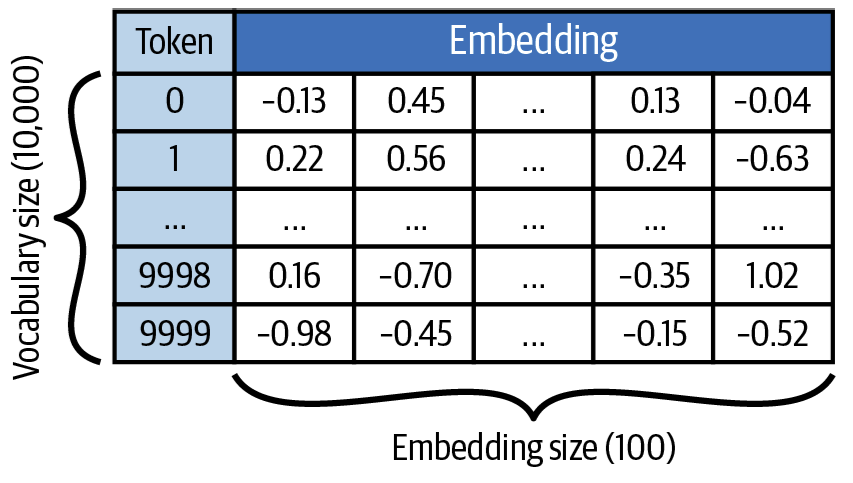

Векторы поиска изучаются моделью как веса нейронной сети. Следовательно, количество весов, изученных этим слоем, равно размеру словаря, умноженному на размерность вектора внедрения (т. е. 10 000 × 100 = 1 000 000).

Мы отображаем (встраиваем) каждый целочисленный токен в непрерывный вектор, поскольку это позволяет модели изучить представление для каждого слова, которое можно обновлять посредством обратного распространения ошибки. Мы также могли бы просто закодировать каждый входной токен при помощи прямого (one-hot) кодирования, однако использование слоя внедрения (embedding) предпочтительнее, поскольку оно делает само встраивание обучаемым, что дает модели большую гибкость в принятии решения о том, как именно встроить каждый токен для повышения его производительности.

Таким образом, входной слой передает тензор целочисленных последовательностей формы `[batch_size, seq_length]` слою внедрения `Embedding`, который выводит (возвращает) тензор формы `[batch_size, seq_length, embedding_size]`. Затем этот тензор передается слою LSTM.

<!--img src="08_arm_02.pdf" width=600-->

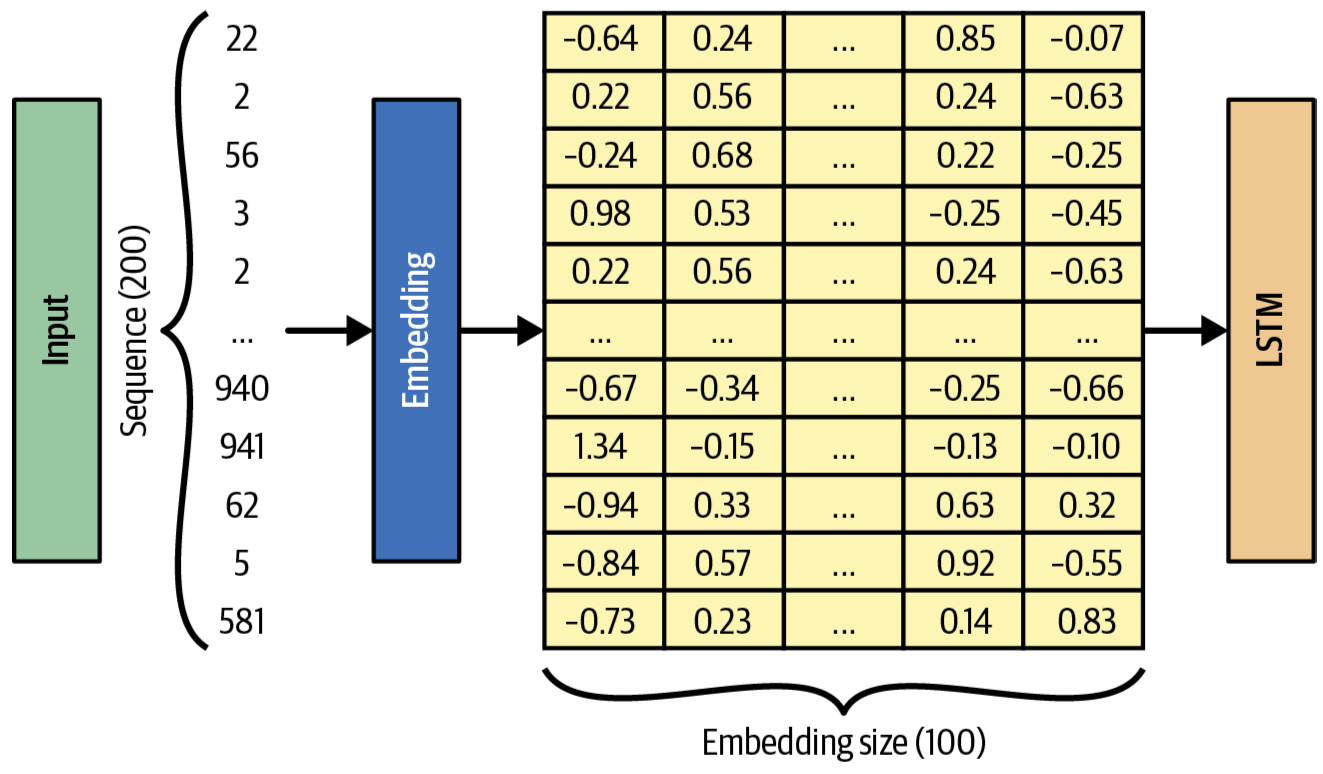

### Слой LSTM

Чтобы понять слой LSTM, мы должны сначала посмотреть, как работает общий рекуррентный слой.

Рекуррентный слой обладает особым свойством обрабатывать последовательные входные данные $x_1, ..., x_n$. Слой состоит из ячейки (cell), которая обновляет свое скрытое состояние $h_t$ по мере прохождения через нее каждого элемента последовательности $x_t$, по одному элементу за раз.

Скрытое состояние представляет собой вектор длиной, равной количеству узлов (units) в ячейке. Его можно рассматривать как текущее понимание ячейкой последовательности данных. На временном шаге $t$ ячейка использует предыдущее значение скрытого состояния $h_{t - 1}$ вместе с данными текущего временного шага $x_t$ для создания обновленного вектора скрытого состояния $h_t$. Этот повторяющийся процесс продолжается до конца последовательности. После завершения последовательности слой выводит окончательное скрытое состояние ячейки $h_n$, которое затем передается на следующий слой сети. Этот процесс показан на рисунке ниже.

<!--img src="08_arm_03.pdf" width=200-->

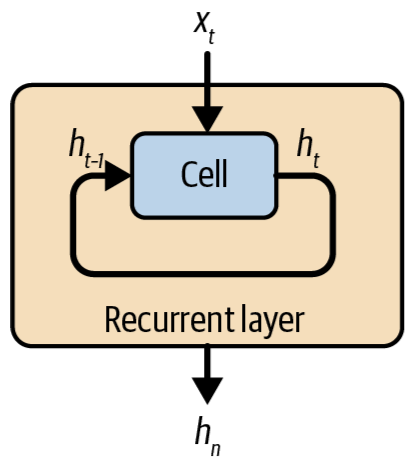

Чтобы рассмотреть это более подробно, развернем процесс так, чтобы мы могли точно увидеть, как одна последовательность данных проходит через слой.

<!--img src="08_arm_04.pdf" width=600-->

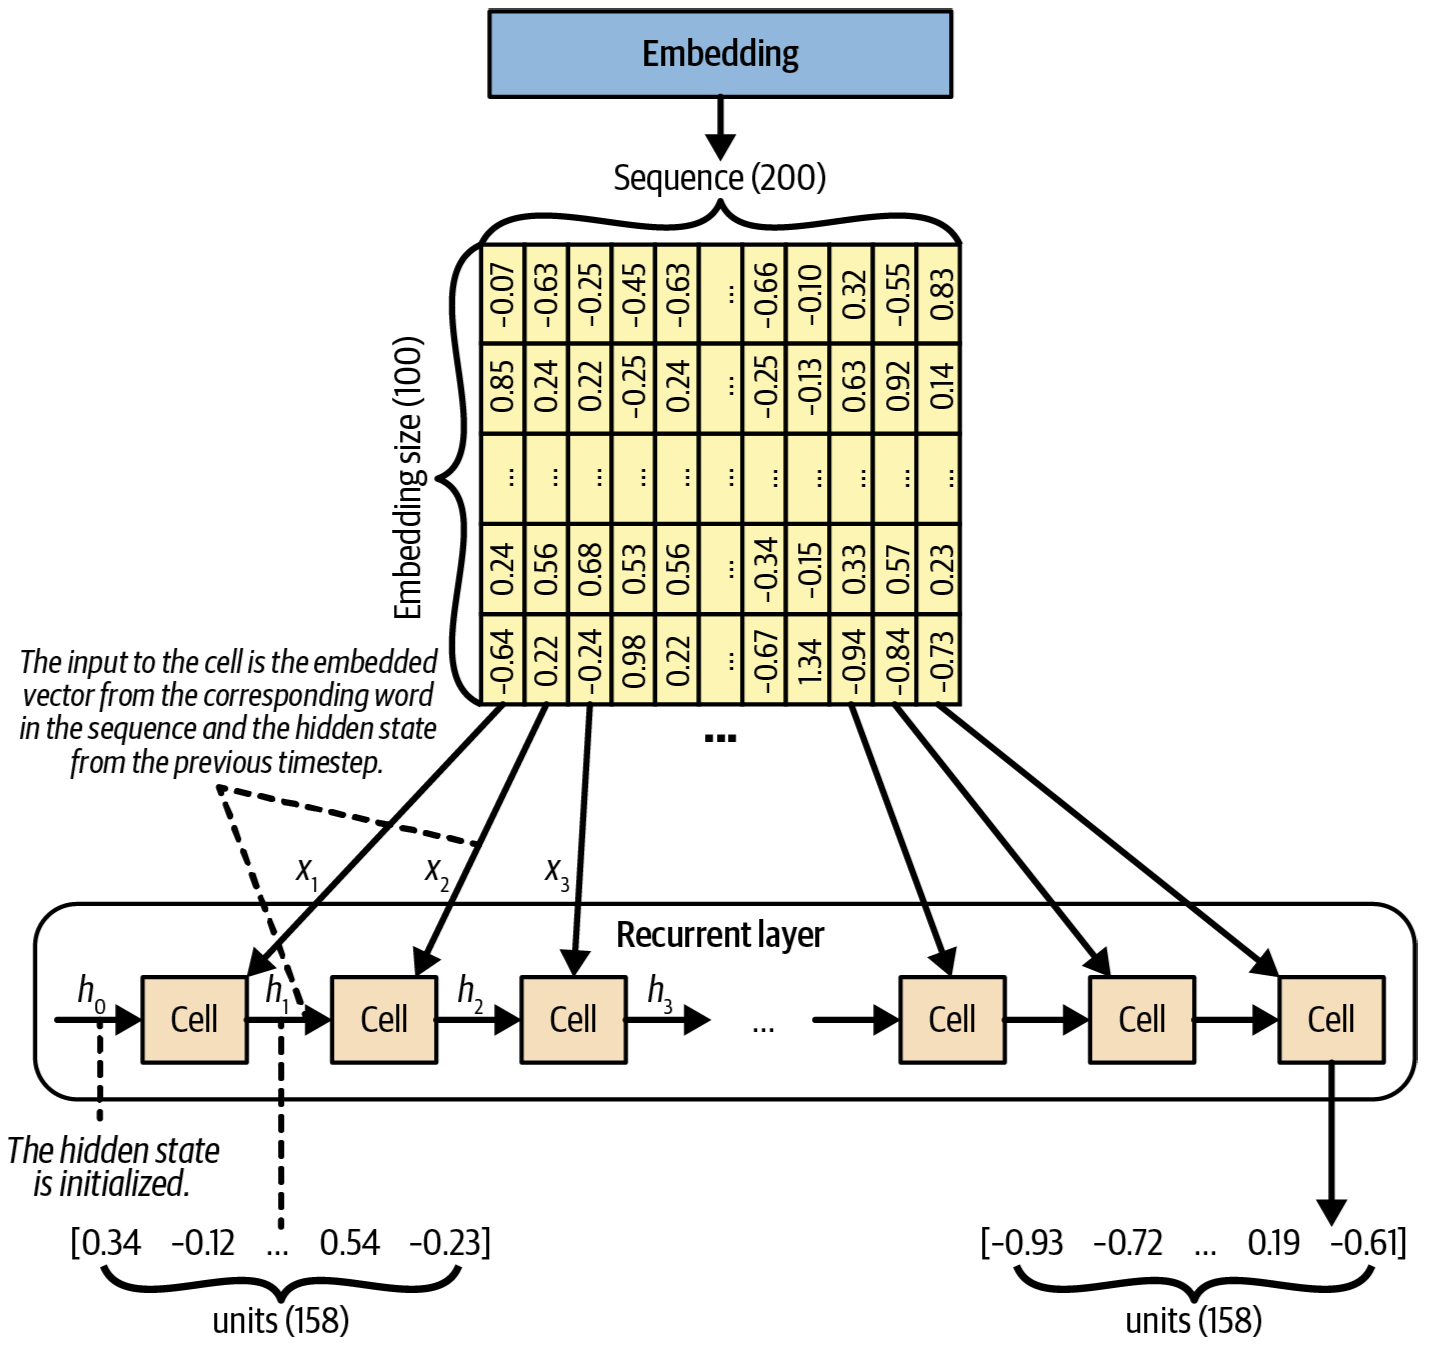

Важно помнить, что все ячейки на диаграмме имеют одинаковые веса (поскольку на самом деле это одна и та же ячейка). 

Здесь представлен повторяющийся процесс с копией  ячейки на каждом временном шаге, и показано, как скрытое состояние постоянно обновляется по мере прохождения через ячейки. Можно ясно видеть, как предыдущее скрытое состояние смешивается с текущей точкой данных в последовательности (т. е. текущим вектором внедрения слова) для создания следующего скрытого состояния. Выходные данные слоя — это окончательное скрытое состояние ячейки после обработки каждого слова во входной последовательности.

### Ячейка LSTM

Теперь, когда мы увидели, как работает общий рекуррентный слой, давайте заглянем внутрь отдельной ячейки LSTM.

Задача ячейки LSTM — вывести новое скрытое состояние $h_t$ с учетом предыдущего скрытого состояния $h_{t − 1}$ и текущего внедрения слова $x_t$. Напомним, длина $h_t$ равна количеству модулей в LSTM. Это параметр, который задается при определении слоя и не имеет никакого отношения к длине последовательности.

Ячейка LSTM поддерживает состояние ячейки $C_t$, которое можно рассматривать как внутренние убеждения ячейки о текущем статусе последовательности. Это отличается от скрытого состояния $h_t$, которое в конечном итоге выводится ячейкой после последнего временного шага. Состояние ячейки имеет ту же длину, что и скрытое состояние (количество узлов в ячейке).
Давайте более внимательно рассмотрим одну ячейку и то, как обновляется скрытое состояние:

<!--img src="08_arm_05.pdf" width=600-->

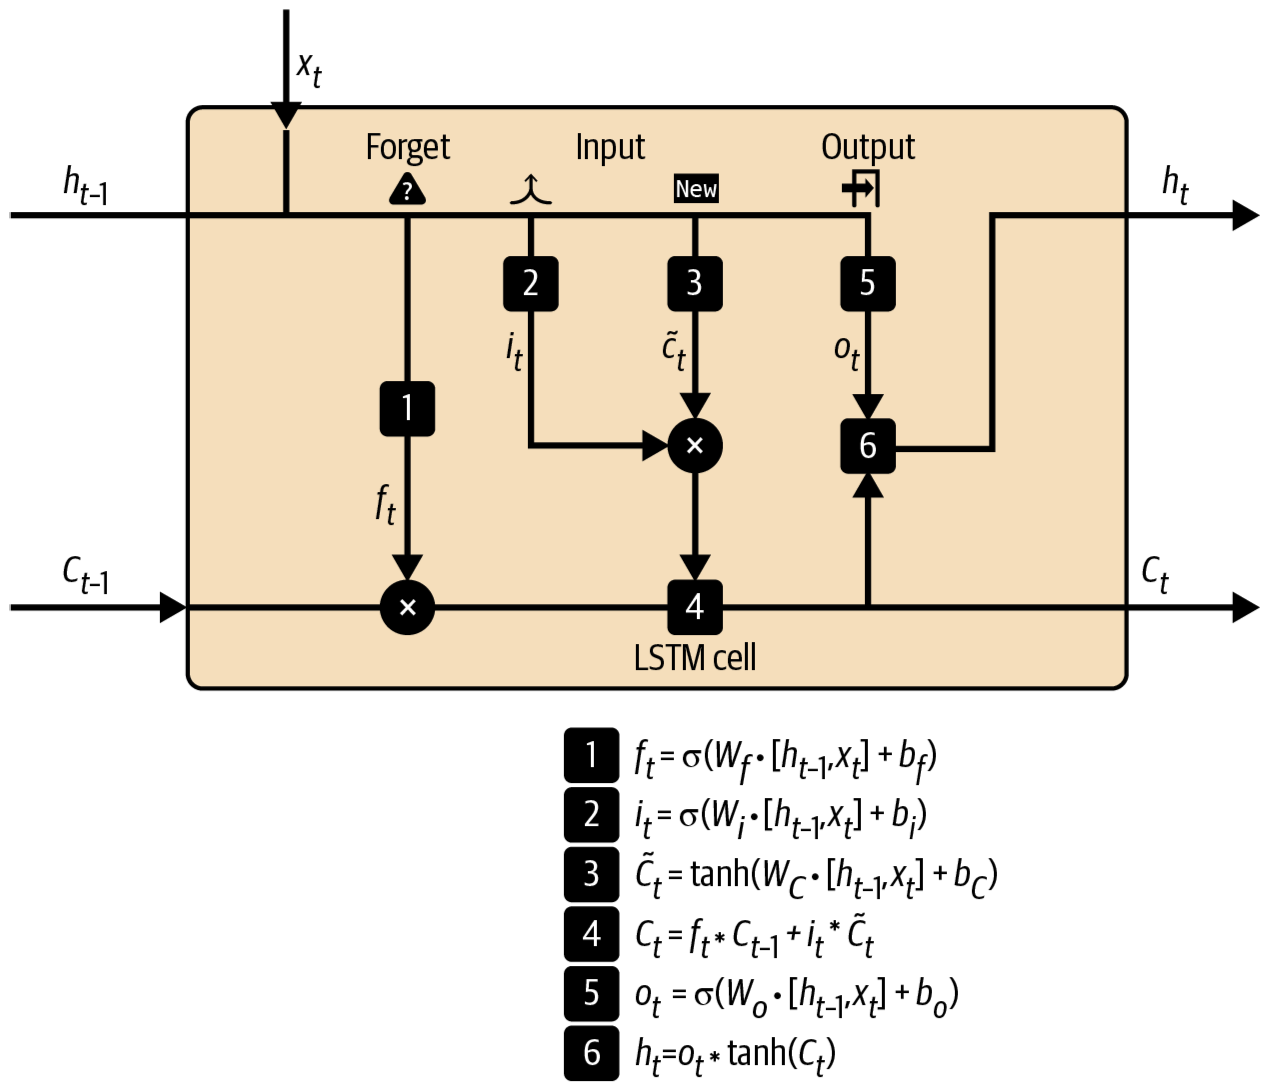

Скрытое состояние обновляется в шесть шагов:

1. Скрытое состояние предыдущего временного шага $h_{t − 1}$ и текущее внедрение (встраивание) слова $x_t$ объединяются и передаются через вентиль (шлюз, gate) забывания. Этот вентиль представляет собой просто плотный слой с матрицей весов $W_f$ , смещением $b_f$ и сигмоидной функцией активации. Результирующий вектор $f_t$ имеет длину, равную количеству узлов в ячейке, и содержит значения от $0$ до $1$, которые определяют, какая часть предыдущего состояния ячейки $C_{t - 1}$ должна быть сохранена.

2. Объединенный вектор $(h_{t − 1}, x_t)$ также проходит через входной вентиль, который, как и вентиль забывания, представляет собой плотный слой с матрицей весов $W_i$, смещением $b_i$ и сигмоидной функцией активации. Выходные данные этого вентиля $i_t$ имеют длину, равную количеству узлов в ячейке, и содержат значения от 0 до 1, которые определяют, сколько новой информации будет добавлено к предыдущему состоянию ячейки $C{t - 1}$.

3. Объединенный вектор $(h_{t − 1}, x_t)$ проходит через плотный слой с матрицей весов $W_C$, смещением $b_C$ и функцией активации $\tanh$ для создания вектора $\tilde{C}_{t}$, содержащего новую информацию, которую ячейка хочет сохранить. Он также имеет длину, равную количеству узлов в ячейке, и содержит значения от –1 до 1.

4. Векторы $f_t$ и $C_{t−1}$ перемножаются поэлементно и добавляются к поэлементному умножению $i_t$ и $\tilde{C}_{t}$. Это представляет собой забывание частей предыдущего состояния ячейки и последующее добавление новой соответствующей информации для создания обновленного состояния ячейки $C_t$.

5. Объединенный вектор пропускается через выходной вентиль: плотный слой с матрицей весов $W_o$, смещением $b_o$ и сигмоидной активацией. Результирующий вектор $o_t$ имеет длину, равную количеству узлов в ячейке, и хранит значения от 0 до 1, которые определяют, какая часть обновленного состояния ячейки $C_t$ будет выведена из ячейки.

6. Вектор $o_t$ умножается поэлементно на обновленное состояние ячейки $C_t$ после применения активации $\tanh$ для создания нового скрытого состояния $h_t$.

Вся сложность слоя LSTM реализована в Keras.

## Обучение сети LSTM

Итак, сеть LSTM для обработки текстов рецептов состоит из следующих слоев:

1. Входной слой `Input`

Входной слой не требует, чтобы мы заранее указывали длину последовательности (она может быть переменной), поэтому мы используем параметр `None`.

2. Слой внедрения `Embedding`

Слою `Embedding` требуются два параметра: размер словаря (10 000 токенов) и размерность вектора внедрения (100).

3. Слой `LSTM`

Слои `LSTM` требуют указания размерности скрытого вектора (128). Также можно возвращать полную последовательность скрытых состояний, а не только скрытое состояние на последнем временном шаге.

4. Выходной слой `Dense`

Плотный слой `Dense` преобразует скрытые состояния на каждом временном шаге в вектор вероятностей для следующего токена.

Модель прогнозирует следующий токен на основе входной последовательности токенов. Это делается для каждого токена в последовательности.

Модель компилируется с функцией потерь `SparseCategoricalCrossentropy` — это то же самое, что категориальная перекрестная энтропия, но используется, когда метки являются целыми числами, а не векторами с прямым (one-hot) кодированием.

In [22]:
loss_fn = losses.SparseCategoricalCrossentropy()
lstm.compile("adam", loss_fn)

### Анализ LSTM

Мы можем начать использовать сеть LSTM для генерации длинных строк текста, применив следующий подход:

1. Направляем на вход сети существующую последовательность слов и просим сеть  предсказать следующее слово.
2. Добавляем это слово к существующей последовательности и повторяем процесс.

Сеть выведет набор вероятностей для каждого слова, из которого мы можем делать выбор. Следовательно, генерация текста может быть стохастической, а не детерминированной. Более того, можно ввести параметр "температура" (`temperature`) в процесс выбора слов, чтобы указать, насколько детерминированным мы хотим видеть этот процесс.

#### Параметр temperature

Параметр `temperature`, близкий к нулю, делает выборку более детерминированной (т. е. с большой вероятностью будет выбрано слово с наибольшей вероятностью), тогда как параметр `temperature`, равный единице, означает, что каждое слово выбирается с вероятностью, выдаваемой моделью.
Это достигается с помощью кода ниже, который создает функцию обратного вызова (callback), которую можно использовать для генерации текста в конце каждой эпохи обучения.

In [23]:
# Create a TextGenerator checkpoint
class TextGenerator(callbacks.Callback):
    def __init__(self, index_to_word, top_k=10):
        self.index_to_word = index_to_word
        self.word_to_index = {
            word: index for index, word in enumerate(index_to_word)
        }  # <1>

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def generate(self, start_prompt, max_tokens, temperature):
        start_tokens = [
            self.word_to_index.get(x, 1) for x in start_prompt.split()
        ]  # <3>
        sample_token = None
        info = []
        while len(start_tokens)<max_tokens and sample_token != 0: #<4>
            x = np.array([start_tokens])
            y = self.model.predict(x, verbose=0)  # <5>
            sample_token, probs = self.sample_from(y[0][-1], 
                                                   temperature)  # <6>
            info.append({"prompt": start_prompt, "word_probs": probs})
            start_tokens.append(sample_token)  # <7>
            start_prompt = start_prompt + " " + \
                        self.index_to_word[sample_token]
        print(f"\ngenerated text:\n{start_prompt}\n")
        return info

    def on_epoch_end(self, epoch, logs=None):
        self.generate("recipe for", max_tokens=100, temperature=1.0)

Комментарии к классу `TextGenerator` следующие:
1. Создаем обратное словарное отображение (от слова к токену).
2. Эта функция обновляет вероятности с помощью коэффициента масштабирования температуры.
3. Начальный промпт (start prompt) — это строка слов, которую вы хотите передать модели для запуска процесса генерации (например, "recipe for"). Слова сначала преобразуются в список токенов.
4. Последовательность генерируется до тех пор, пока ее длина не достигнет значения `max_tokens` или пока не будет создан стоп-токен (0).
5. Модель выводит вероятности того, что каждое слово будет следующим в последовательности. 
6. Вероятности пропускаются через сэмплер, параметризованный температурой, для вывода следующего слова.
7. Мы добавляем новое слово к тексту промпта, готовые к следующей итерации генеративного процесса.

In [25]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
text_generator = TextGenerator(vocab)

In [26]:
lstm.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback, 
               tensorboard_callback, 
               text_generator],
)

Epoch 1/25
628/629 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.0518
generated text:
recipe for style tablespoons all balls together white orange solids | batter with shallow at ground leaves and banana pan , vinegar until inch quesadillas ingredients , ) and season and using up . a processor heat cool to a heavy fry , heat , in large aside until tender . wrap . remove half . let volume and off seeds . cover egg over about medium bowl and add butter , 4 cups to beat eggs , 1 water . cut with 1 / beat to 4 inch minutes in off maker . cover . set to wooden )

629/629 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - loss: 4.1609
Epoch 2/25
629/629 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.0215
generated text:
recipe for herb powder and bloody t smothered , harissa | cake the ice in 1 / 3 pastry each down . serve the asado with salt and bitters and rolling segments and preheat well to put . watch since dough into a knife cookie pan , about 1 / 2 / 4 cup pieces , garlic on a large heat - ounce electri

628/629 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.6884
generated text:
recipe for curly filet honeydew sandwiches with tortillas roulade salad | cook cabbage in large saucepan of boiling salted water until tender , 2 3 / 4 - to 2 minutes . transfer potatoes to a blender and add to fat in another bowl . do ahead : tapenade can be made 1 month ahead . store airtight at room temperature . do ahead : can be made 2 days ahead . keep warm . preheat oven to 350°f . sprinkle evenly with salt and pepper . bake tomatoes in center of bowl , until soft , 5 to 20

629/629 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - loss: 1.6840
Epoch 14/25
629/629 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.6608
generated text:
recipe for sweet potato and sour cream | in a reserving pan , blanch peppers in a covered 10 until tender , 4 minutes . drain and coarsely chop . while pasta is very the boiling liquid , in a large saucepan soak the onion over moderate heat , stirring , until the side is softened . while tan hole

In [28]:
# Save the final model
lstm.save("./models/lstm.keras")

## Генерация текста при помощи сети LSTM

Функция `print_probs` выводит текущее значение промпта и слова, соответствующие токенам с наиболее высокими вероятностями.

In [29]:
def print_probs(info, vocab, top_k=5):
    for i in info:
        print(f"\nPROMPT: {i['prompt']}")
        word_probs = i["word_probs"]
        p_sorted = np.sort(word_probs)[::-1][:top_k]
        i_sorted = np.argsort(word_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted):
            print(f"{vocab[i]}:   \t{np.round(100*p,2)}%")
        print("--------\n")

Сгенерируем текст для двух различных значений параметра `temperature`. 

In [30]:
info = text_generator.generate(
    "recipe for roasted vegetables | chop 1 /", 
    max_tokens=10, temperature=1.0
)


generated text:
recipe for roasted vegetables | chop 1 / 8 -



In [31]:
print_probs(info, vocab)


PROMPT: recipe for roasted vegetables | chop 1 /
2:   	47.9900016784668%
4:   	32.63999938964844%
3:   	12.329999923706055%
8:   	2.4200000762939453%
dice:   	0.5199999809265137%
--------


PROMPT: recipe for roasted vegetables | chop 1 / 8
-:   	21.440000534057617%
cup:   	11.899999618530273%
inch:   	9.609999656677246%
stick:   	6.010000228881836%
pounds:   	5.960000038146973%
--------



In [32]:
info = text_generator.generate(
    "recipe for roasted vegetables | chop 1 /", 
    max_tokens=10, temperature=0.2
)


generated text:
recipe for roasted vegetables | chop 1 / 2 cup



In [33]:
print_probs(info, vocab)


PROMPT: recipe for roasted vegetables | chop 1 /
2:   	87.20999908447266%
4:   	12.699999809265137%
3:   	0.10000000149011612%
8:   	0.0%
dice:   	0.0%
--------


PROMPT: recipe for roasted vegetables | chop 1 / 2
cup:   	99.83999633789062%
inch:   	0.09000000357627869%
-:   	0.029999999329447746%
pounds:   	0.019999999552965164%
garlic:   	0.009999999776482582%
--------



In [34]:
info = text_generator.generate(
    "recipe for chocolate ice cream |", max_tokens=7, temperature=1.0
)
print_probs(info, vocab)


generated text:
recipe for chocolate ice cream | lightly


PROMPT: recipe for chocolate ice cream |
in:   	14.40999984741211%
preheat:   	13.119999885559082%
combine:   	10.899999618530273%
bring:   	10.0%
heat:   	4.0%
--------



In [35]:
info = text_generator.generate(
    "recipe for chocolate ice cream |", max_tokens=7, temperature=0.2
)
print_probs(info, vocab)


generated text:
recipe for chocolate ice cream | in


PROMPT: recipe for chocolate ice cream |
in:   	49.029998779296875%
preheat:   	30.700000762939453%
combine:   	12.130000114440918%
bring:   	7.869999885559082%
heat:   	0.07999999821186066%
--------



Модель способна генерировать подходящее распределение для следующего наиболее вероятного слова в различных контекстах. Например, хотя модели никогда не сообщалось о таких частях речи, как существительные, глаголы или числа, она, как правило, способна разделять слова на эти классы и использовать их грамматически правильно.